In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
import sklearn as sk
from sklearn import model_selection

Error for learner  1 :  0.6457960644007156
Error for learner  2 :  0.5080500894454383
Error for learner  3 :  0.8085867620751341
Error for learner  4 :  0.5241502683363148
Error for learner  5 :  0.8354203935599285
Error for learner  6 :  0.8872987477638641
Error for learner  7 :  0.5330948121645797
Error for learner  8 :  0.5366726296958855
Error for learner  9 :  0.8676207513416816
Error for learner  10 :  0.8318425760286225
Error for learner  11 :  0.8443649373881932
Error for learner  12 :  0.5652951699463328
Error for learner  13 :  0.5813953488372093
Error for learner  14 :  0.5849731663685152
Error for learner  15 :  0.5635062611806798
Error for learner  16 :  0.5313059033989267
Error for learner  17 :  0.5778175313059034
Error for learner  18 :  0.6261180679785331
Error for learner  19 :  0.5760286225402504
Error for learner  20 :  0.5796064400715564
Error for learner  21 :  0.5652951699463328
Error for learner  22 :  0.5491949910554562
Error for learner  23 :  0.52057245080500

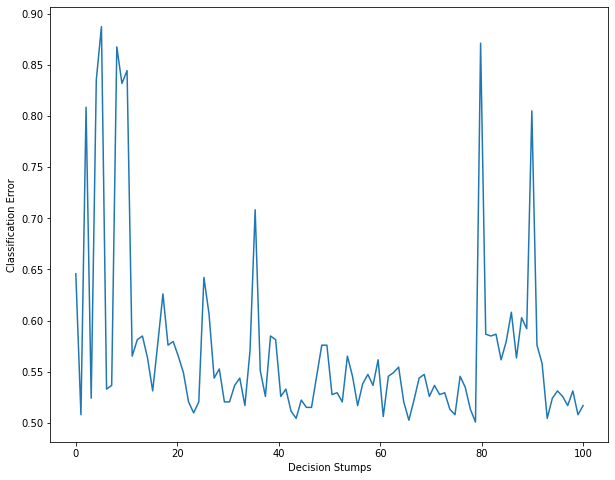

In [ ]:
def Adaboost(X, y, learners):
  y_original = y
  X_original = X
  w = np.ones(shape = X.shape[0])/X.shape[0]
  alphas = []
  prediction_thresholds = []
  signs = []
  errors = []

  for t in range(learners):
    entropy = []
    conditional_entropy = []

    for feature in range(X.shape[1]):
      entropy = np.append(entropy, get_entropy(X[:, feature])) 
      conditional_entropy = np.append(conditional_entropy, get_conditional_entropy(X[:, feature], y))

    information_gain = get_information_gain(entropy, conditional_entropy)
    max_index = np.argmax(information_gain)
    split_feature = X[:,max_index]
    
    # Methods 1: With Binary Classification
    confusion = confusion_matrix(split_feature, y)
    threshold = binary(split_feature, confusion, y)
    sign = get_sign(split_feature, threshold, y)

    # Methods 2
    #Zeros out messing up the resampling
    #threshold, sign = best_threshold(split_feature, y)

    prediction_thresholds = np.append(prediction_thresholds, threshold)
    signs = np.append(signs, sign)
    predictions = predict(split_feature, threshold, sign)
    indicator = np.where(predictions != y, 1, 0)
    error = np.sum(indicator)/len(indicator)
    errors = np.append(errors, error)
    print("Error for learner ", t + 1,": ", error)

    e_t = w.dot(indicator.T)
    alpha_t = (1/2)*np.log((1-e_t)/e_t)
    alphas = np.append(alphas, alpha_t)
    exp = np.exp(-alpha_t*(y*predictions))
    Z_t = w.dot(exp)
    w = (w*exp)/Z_t
    # Testing passing in the original values
    X, y = resample(w, X_original, y_original)
    # Stepper 
    #input("Press Enter to continue...")

  return alphas, prediction_thresholds, signs, errors

def test(X, y, alphas, thresholds, sign, learners):
  g_x = []
  error = 0

  for row in X:
    for t in range(learners):
      if sign[t] == 1:
        G_t = np.where(row >= thresholds[t], 1, -1)
        g_x = np.append(g_x, np.sign(np.sum(alphas[t]*G_t)))      

      elif sign[t] == 2:
          G_t = np.where(row < thresholds[t], 1, -1)
          g_x = np.append(g_x, np.sign(np.sum(alphas[t]*G_t)))  


  for prediction, label in zip(g_x, y):
    if prediction != label:
      error += 1

  return (1 - (error/len(y)))


def best_threshold(feature, y):
  unique_x, counts_x = np.unique(feature, return_counts=True)
  unique_y, counts_y = np.unique(y, return_counts=True)
  # Sorts in ascending order
  sorted_elements = np.sort(unique_x)
  index = 1
  thresholds = []
  errors_above = []
  errors_below = []
  

  for i in range(len(sorted_elements) - 2):
    thresholds = np.append(thresholds, (sorted_elements[index - 1] + sorted_elements[index]) / 2 )
    index += 1

  for i in thresholds:
    # Value >= threshold --> -1
    predictions_above = np.where(feature >= i, 1, -1)
    error = np.where(predictions_above != y, 1, 0)
    errors_above = np.append(errors_above, np.sum(error)/len(y))
    # Value < threshold --> +1
    predictions_below = np.where(feature < i, 1, -1)
    error = np.where(predictions_below != y, 1, 0)
    errors_below = np.append(errors_below, np.sum(error)/len(y))

  min_above_index = np.argmin(errors_above)
  min_above_error = errors_above[min_above_index]
  min_below_index = np.argmin(errors_below)
  min_below_error = errors_below[min_below_index]

  # Below --> Sign 2
  if min_below_error < min_above_error:
    return thresholds[min_below_index], 2 

  # Above --> Sign 1
  else:
    return thresholds[min_above_index], 1


def resample(w, prev_data, prev_y):
  index = np.random.choice(prev_data.shape[0], prev_data.shape[0], replace=True, p = np.ndarray.flatten(w))
  resample_X = prev_data[index]
  resample_y = prev_y[index]
  
  return resample_X, resample_y


def get_entropy(feature):
  unique_elements, counts = np.unique(feature, return_counts=True)
  p_x = counts/np.sum(counts)

  return -(p_x.dot(np.log2(p_x)))


def _get_entropys(p_x1, p_x2):
  
  return -(p_x1*np.log2(p_x1) + p_x2*np.log2(p_x2))


def get_conditional_entropy(feature, y):
  unique_y, counts_y = np.unique(y, return_counts=True)
  unique_x, counts_x = np.unique(feature, return_counts=True)
  confusion = confusion_matrix(feature, y)
  p_x = counts_x/np.sum(counts_x)
  joint_entropy = []
  
  for rows in confusion:
    p_x1 = rows[0]/len(feature)
    p_x2 = rows[1]/len(feature)
    
    if p_x1 == 0 or p_x2 == 0:
      joint_entropy = np.append(joint_entropy, 0)

    else:
      joint_entropy = np.append(joint_entropy, _get_entropys(p_x1, p_x1))

  conditional_entropy = p_x.dot(joint_entropy)

  return conditional_entropy


def get_information_gain(entropy, conditional_entropy):
  return entropy - conditional_entropy


def confusion_matrix(feature, y):
  unique_x, counts_x = np.unique(feature, return_counts=True)
  max = np.argmax(unique_x)
  confusion_positive = np.zeros(unique_x[max])
  confusion_negative = np.zeros(unique_x[max])
  
  for i,j in zip(feature, y):
    if j == 1:
      confusion_positive[i - 1] += 1

    elif j == -1:
      confusion_negative[i - 1] += 1
  
  confusion = np.vstack((confusion_positive, confusion_negative)).T

  return confusion[~np.all(confusion == 0, axis = 1)]


def binary(feature, confusion, y):
  unique_x, counts_x = np.unique(feature, return_counts=True)
  unique_y, counts_y = np.unique(y, return_counts=True)
  # {-1, 1}
  priors = counts_y/sum(counts_y)
  posterior = []
  
  for rows in confusion:
    p = priors[1]*(rows[0]/len(feature)) + priors[0]*(rows[1]/len(feature))
    posterior = np.append(posterior, p)

  threshold_index = unique_x[np.argmax(posterior)]

  return threshold_index


def predict(feature, threshold, sign):
  
  if sign == 1:
    # Was -1, 1
    predictions = np.where(feature >= threshold, 1, -1)      

  else:
    # Was 1, -1,
    predictions = np.where(feature < threshold, 1, -1)

  return predictions


def get_sign(feature, threshold, y):
  predictions = np.array([np.where(feature <  threshold, 1, -1),
                          np.where(feature >= threshold, 1, -1)])
  errors = []

  for guesses in predictions:
    error = 0
    
    for guess, label in zip(guesses, y):
      if guess != label:
        error += 1

    errors = np.append(errors, error/len(y))

  return np.argmin(errors) + 1

def main():
  plt.figure(figsize=(10,8))
  np.set_printoptions(threshold=np.inf)
  bc_data = np.loadtxt("/content/drive/MyDrive/breast-cancer-wisconsin-mode.csv", dtype=int,delimiter = ",")
  X = bc_data[:,1:-1]
  y = bc_data[:,-1]
  y = np.where(y == 2, 1, -1)
  X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, train_size = 0.8)

  LEARNERS = 100
  alphas, thresholds, signs, errors = Adaboost(X_train, y_train, LEARNERS)
  accuracy = test(X_test, y_test, alphas, thresholds, signs, LEARNERS)
  print("Testing accuracy: ", accuracy)

  x = np.linspace(0, 100, 100)
  plt.plot(x, errors)
  plt.xlabel("Decision Stumps")
  plt.ylabel("Classification Error")

if __name__ == "__main__":
  main()